In [1]:
import math
import itertools
import random
import torch
import numpy as np
import torch.nn.functional
import matplotlib.pyplot as plt
import torch.optim as opt
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
import copy
import scipy.stats as st
from sklearn.datasets.samples_generator import make_blobs
from matplotlib.colors import LogNorm
import matplotlib.cm as cm
import torch.distributions as D
import torch.nn.functional as F
from scipy.interpolate import griddata

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
print(dev)

cuda:0


D:\ComputerSoftwares\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# global veriable
Uniform_low_bound = 0
Uniform_up_bound = 1
Agent_number_n = 3
number_of_groups = 2
Normal_loc = 0.5
Normal_scale = 0.2
Normal_loc1 = 0
Normal_loc2 = 1.5
Normal_scale1 = 0.5
Normal_scale2 = 0.5
Distribution_number = 10000
Multiple = 4
beta_a = 0.3
beta_b = 0.2
cauchyloc = 1.0/Agent_number_n
cauchyscalen = 0.004
kumaraswamy_a = beta_a
kumaraswamy_b = (1.0 + (beta_a - 1.0) * math.pow(
    (beta_a + beta_b - 2.0) / (beta_a - 1.0), beta_a)) / beta_a
print(kumaraswamy_b)

independentnormalloc1 = [(float(ii) + 1) / (2 * Agent_number_n + 1)
                         for ii in range(Agent_number_n, 0, -1)]
independentnormalscale1 = [0.05 for ii in range(Agent_number_n)]

independentnormalloc2 = [(float(ii) + 1) / (2 * Agent_number_n + 1)
                         for ii in range(1, Agent_number_n + 1, 1)]
independentnormalscale2 = [0.05 for ii in range(Agent_number_n)]
exponentialhigh = 15  #Symbol("b", real=True)
exponentiallow = 15  #Symbol("a", real=True)

target = "min_sum" 
order = "normal"
# "twopeak","normal","uniform","independent1","independent2","cauchy","beta","U-exponential","arcsine"
order1name = ["dp", "random initializing", "costsharing", "heuristic"]
# "costsharing","dp","heuristic","random initializing"

0.40058530825361593


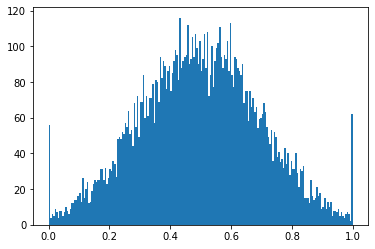

5000
[[0.87100255 0.47569352 0.59480744]
 [0.44580099 0.33341374 0.87415917]
 [0.81020599 0.64803864 0.50817324]]
5000


In [3]:
seed = 7
np.random.seed(seed)
# exec(open('distribution/twopeak.py').read())
#exec(open('../distribution/twopeaknormal.py').read())
exec(open('../../distribution/normal.py').read())
X_train, X_test = train_test_split(value_list,
                                   test_size=0.5,
                                   random_state=seed)
for i in range(len(value_list)):
    for j in range(len(value_list[0])):
        if (value_list[i][j] <= 0):
            value_list[i][j] = 0
        if (value_list[i][j] >= 1):
            value_list[i][j] = 1

value_list1 = np.array(value_list)
for i in range(min(Agent_number_n, 1)):
    pa = value_list1[:, i]
    plt.hist(pa, bins=200)
    plt.show()

dataset_size = len(X_train)
print(dataset_size)
print(np.array(X_train[:3]))
print(len(X_test))
# run_cs()

In [4]:
d1 = D.normal.Normal(Normal_loc1, Normal_scale1)
d2 = D.normal.Normal(Normal_loc2, Normal_scale2)
distributionRatio1 = (d1.cdf(1) + d2.cdf(1) - d1.cdf(0) - d2.cdf(0)) / 2
distributionBase1 = d1.cdf(0) + d2.cdf(0)

d3 = D.normal.Normal(Normal_loc, Normal_scale)
distributionRatio3 = d3.cdf(1) - d3.cdf(0)
distributionBase3 = d3.cdf(0)

d4 = D.uniform.Uniform(0.0, 1.0)
distributionRatio4 = d4.cdf(1) - d4.cdf(0)
distributionBase4 = d4.cdf(0)

d5 = [
    D.normal.Normal(independentnormalloc1[ii], independentnormalscale1[ii])
    for ii in range(Agent_number_n)
]
d6 = [
    D.normal.Normal(independentnormalloc2[ii], independentnormalscale2[ii])
    for ii in range(Agent_number_n)
]

d7 = D.cauchy.Cauchy(cauchyloc, cauchyscalen)
d81 = D.exponential.Exponential(exponentiallow)
d82 = D.exponential.Exponential(exponentialhigh)

d9 = D.beta.Beta(beta_a, beta_b)
d10 = D.beta.Beta(0.5, 0.5)


def cdf(x, y, i=None):
    if (y == "twopeaknormal"):
        return (d1.cdf(x) + d2.cdf(x) ) / 2 #/ distributionRatio1
    elif (y == "normal"):
        return (d3.cdf(x) - distributionBase3) #/ distributionRatio3
    elif (y == "uniform"):
        return (d4.cdf(x) - distributionBase4) #/ distributionRatio4
    elif (y == "independent1"):
        return d5[i].cdf(x)
    elif (y == "independent2"):
        return d6[i].cdf(x)
    elif (y == "cauchy"):
        return d7.cdf(x)
    elif (y == "beta"):
        if (x < 0.0000001):
            x = 0.0000001
        elif (x > 0.9999999):
            x = 0.9999999
        try:
            return 1.0 - torch.pow(1.0 - torch.pow(x, kumaraswamy_a),
                                   kumaraswamy_b)
        except:
            return 1.0 - torch.pow(
                1.0 - torch.pow(torch.tensor(x, dtype=torch.float32),
                                kumaraswamy_a), kumaraswamy_b)
    elif (y == "arcsine"):
        #
        if (x < 0.0000001):
            x = 0.0000001
        elif (x > 0.9999999):
            x = 0.9999999
        try:
            res = 2.0 / math.pi * torch.asin(torch.sqrt(x))
            # print(x)
            return res  # + 0.0001*1.0/(
            # math.pi * torch.sqrt(torch.tensor(x)*torch.tensor(1.0-x)))
        except:
            return 2.0 / math.pi * torch.asin(
                torch.sqrt(torch.tensor(
                    x, dtype=torch.float32)))  # + 0.0001*1.0/(
            # math.pi * torch.sqrt(torch.tensor(x)*torch.tensor(1.0-x)))
    elif (y == "U-exponential"):
        return (d81.cdf(x) + (1.0 - d82.cdf(1.0 - x))) / 2

In [5]:
x=torch.nn.Parameter(torch.tensor(0.2,
                                                      requires_grad=True),
                                           requires_grad=True).cuda()
print(cdf(1.3717421124828532235939643347051, order))

print(cdf(0.5, order))

tensor(0.9938)
tensor(0.4938)


In [6]:
def cost_sharing_with_deadline(test,t_c,target):
    temp_max_delay_list=[0 for i in range(len(test))]
    temp_sum_delay=0
    result=False
    for k in range(len(test),0,-1):
        count=0;
        delay=0;
        for ii in range(len(test)):
            item= test[ii]
            if(item+1e-9>=target/k):
                count+=1;
            else:
                delay+=t_c[ii];
                temp_max_delay_list[ii]=t_c[ii]
            
        if(count>=k):
            temp_sum_delay+=delay;
            result=True
            break;
        if(k<=1):
            #print(test,number_n);
            temp_max_delay_list=t_c
            temp_sum_delay=sum(t_c);
            result=False
            
    return temp_max_delay_list,temp_sum_delay,result

In [7]:
allBits = [torch.tensor(bits, dtype=torch.int16) for bits in itertools.product([0, 1], repeat=Agent_number_n * Multiple)]

In [8]:
def weight_init(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight,
                                     gain=nn.init.calculate_gain('relu'))
        torch.nn.init.zeros_(m.bias)
    elif isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)


class Net(torch.nn.Module):
    def __init__(self):

        super(Net, self).__init__()

        num_input = Agent_number_n * Multiple
        num_hidden = 20
        num_output = Agent_number_n * Multiple

        self.hidden_0 = torch.nn.Linear(num_input, num_hidden)
        self.hidden_1 = torch.nn.Linear(num_hidden, num_hidden)
        self.hidden_2 = torch.nn.Linear(num_hidden, num_hidden)
        self.output = torch.nn.Linear(num_hidden, num_output)

    def model(self, bits):
        h1 = torch.relu_(self.hidden_0(bits))
        # h1 = torch.relu_(self.hidden_0(value_tensor))
        h2 = torch.relu_(self.hidden_1(h1))
        h3 = torch.relu_(self.hidden_2(h2))
        h4 = self.output(h3)  # no relu!!!!
        # torch.sigmoid(self.deadline)# need more layer
        payment = torch.sigmoid(h4)

        return payment

    def bitsToPayments(self, bits):
        if torch.sum(bits).item() == 0:
            return torch.ones(Agent_number_n * Multiple).cuda()
        bits = bits.type(torch.float32).cuda()
        negBits = torch.ones(Agent_number_n * Multiple).cuda() - bits
        payments = self.model(bits)
        payments = payments - 1000 * negBits
        payments = torch.softmax(payments, 0)
        payments = payments + negBits
        return payments

    def tpToBits(self, tp, bits=torch.ones(Agent_number_n * Multiple).type(torch.uint8).cuda()):
        payments = self.bitsToPayments(bits)
        
#         print(tp)
#         print(payments)
#         print(tp >= payments)
        
        newBits = (tp >= payments).type(torch.uint8).cuda()
        if torch.equal(newBits, bits):
            return bits
        else:
            # bits-bits#tpToBits(tp, newBits)
            return self.tpToBits(tp, newBits)

    def tpToPayments(self, tp):
        return self.bitsToPayments(self.tpToBits(tp))

    def tpToTotalDelay(self, tp):
        if(target == "min_max"):
            print("not work")
            #return torch.max(torch.tensor(0.0), torch.dot(tp, self.tpToBits(tp).type(torch.float32))-1.0)
        if(target == "min_sum"):
            bat = torch.ones(Agent_number_n * Multiple).cuda()
            for i in range(Agent_number_n):
                bat[i*4] *=0.1
                bat[i*4+1] *=0.2
                bat[i*4+2] *=0.3
                bat[i*4+3] *=0.4
            return Agent_number_n - torch.sum(self.tpToBits(tp).type(torch.float32)* bat )
        
        

    def forward(self, value_list):

        loss_condition = 0
        loss_sum_delay = 0
        loss_max_delay = 0
        
        for k in range(len(value_list)):
            
            value_multiple = []
            for i in range(len(value_list[k])):
                value_multiple.append(value_list[k][i]*0.1)
                value_multiple.append(value_list[k][i]*0.2)
                value_multiple.append(value_list[k][i]*0.3)
                value_multiple.append(value_list[k][i]*0.4)
                
            for i in range(len(value_multiple)):
                test = copy.deepcopy(value_multiple)
                test_change = torch.from_numpy(
                    np.array(test)).cuda().type(torch.float32)
                tp_1 = test_change.clone()
                tp_1[i] = 1
                tp_0 = test_change.clone()
                tp_0[i] = 0
                offer = self.tpToPayments(tp_1)[i]
  

                Delay_1 = self.tpToTotalDelay(tp_1)
                Delay_2 = self.tpToTotalDelay(tp_0)

                temp = ((1.0 - cdf(offer, order)) * Delay_1 + cdf(
                    offer, order) * Delay_2)
                loss_sum_delay += temp/len(value_multiple)

            penalty = 0
            penaltyLambda = 10
            
            for jj in range(10):
                index_random_1 = random.randint(0, len(allBits) - 1)
                bitsMoreOnes = allBits[index_random_1]
                for ii in range(Agent_number_n * Multiple):
                    if bitsMoreOnes[i] == 1:
                        bitsLessOnes = bitsMoreOnes.clone()
                        bitsLessOnes[i] = 0
                        penalty = penalty + torch.sum(
                            torch.relu(
                                self.bitsToPayments(bitsMoreOnes) -
                                self.bitsToPayments(bitsLessOnes)
                            )
                        )
            loss_condition += penalty * penaltyLambda


        if(target == "min_sum"):
            loss = loss_sum_delay + loss_condition * 10
        if(target == "min_max"):
            loss = loss_max_delay + loss_condition * 10
        
        return loss, loss_sum_delay, loss_max_delay, float(loss_condition)

In [9]:
random.seed(2000)
torch.manual_seed(256)
net = Net()
# net.apply(weight_init)
net = torch.load("Deep_learning_with_deadline_3_1")
net.to(dev)

#optimizer = opt.RMSprop(net.parameters(), lr=0.00001)
#optimizer = opt.SGD(net.parameters(), lr=0.002)
optimizer = opt.Adam(net.parameters(), lr=0.00002)

batch_size = 8
echo_number = 5001

In [10]:
for echo in range(int(echo_number)):

    # offender_types = []
    # defender_types = []
    denominator = 0
    """
    for j in range(batch_size):
        offender_types.append(random.randint(0, 400))
        defender_types.append(random.randint(0, 15))
    """
    X_train_list = []
    for batch in range(batch_size):
        index_random = random.randint(0, len(X_train) - 1)
        X_train_list.append(X_train[index_random])
        denominator += 1


    h_loss, h_delay_sum, h_delay_max, h_condition = net(X_train_list)
    
    h_loss /= denominator
    h_delay_sum /= denominator
    h_delay_max /= denominator
    h_condition /= denominator
    
    
    loss = h_loss
        

    optimizer.zero_grad()
    #loss = torch.square(loss_function(loss_sum / denominator) + 52)

    loss.backward()
    optimizer.step()

    if echo % 50 == 0:
        print("echo: ", echo)
        print("batch_loss: %.2f " % float(loss))
        print()
        print("sum:  %.2f"% float(h_delay_sum),"  max:  %.2f"% float(h_delay_max) )
        print("condition:  %.2f"%h_condition, "  total_loss:  %.2f"% float(h_loss))
        print("value: ", X_train[index_random])
        print()

echo:  0
batch_loss: 1.73 

sum:  1.73   max:  0.00
condition:  0.00   total_loss:  1.73
value:  [0.25574796 0.5886169  0.45940323]

echo:  50
batch_loss: 2.21 

sum:  2.21   max:  0.00
condition:  0.00   total_loss:  2.21
value:  [0.48566182 0.7966565  0.43013118]

echo:  100
batch_loss: 1.42 

sum:  1.42   max:  0.00
condition:  0.00   total_loss:  1.42
value:  [0.43885032 0.69933932 0.76038337]

echo:  150
batch_loss: 2.28 

sum:  2.28   max:  0.00
condition:  0.00   total_loss:  2.28
value:  [0.50463917 0.3830953  0.59433671]

echo:  200
batch_loss: 2.89 

sum:  2.89   max:  0.00
condition:  0.00   total_loss:  2.89
value:  [0.19001782 0.4865159  0.54811311]

echo:  250
batch_loss: 2.38 

sum:  2.38   max:  0.00
condition:  0.00   total_loss:  2.38
value:  [0.73428754 0.6280574  0.43375936]

echo:  300
batch_loss: 1.22 

sum:  1.22   max:  0.00
condition:  0.00   total_loss:  1.22
value:  [0.56123744 0.4497524  0.97797723]

echo:  350
batch_loss: 1.71 

sum:  1.71   max:  0.00
cond

echo:  3050
batch_loss: 1.50 

sum:  1.50   max:  0.00
condition:  0.00   total_loss:  1.50
value:  [0.7684736  0.68681957 0.50503231]

echo:  3100
batch_loss: 1.84 

sum:  1.84   max:  0.00
condition:  0.00   total_loss:  1.84
value:  [0.82830463 0.68675293 0.38599474]

echo:  3150
batch_loss: 2.36 

sum:  2.36   max:  0.00
condition:  0.00   total_loss:  2.36
value:  [0.49982192 0.14905514 0.7035316 ]

echo:  3200
batch_loss: 2.35 

sum:  2.35   max:  0.00
condition:  0.00   total_loss:  2.35
value:  [0.33330239 0.19162812 0.28006944]

echo:  3250
batch_loss: 1.01 

sum:  1.01   max:  0.00
condition:  0.00   total_loss:  1.01
value:  [0.79968014 0.5335649  0.898872  ]

echo:  3300
batch_loss: 2.37 

sum:  2.37   max:  0.00
condition:  0.00   total_loss:  2.37
value:  [0.49544305 0.35628663 0.73915719]

echo:  3350
batch_loss: 2.18 

sum:  2.18   max:  0.00
condition:  0.00   total_loss:  2.18
value:  [0.71496639 0.67634026 0.29197639]

echo:  3400
batch_loss: 2.27 

sum:  2.27   max:

KeyboardInterrupt: 

In [ ]:
torch.save(net, "Deep_learning_with_deadline_3_2")

In [ ]:
denominator = 0
loss_sum =0 
sum_delay = 0
max_delay = 0
loss_condition =0 
for j in range(100):
    index_random = random.randint(0, len(X_test) - 1)
    h_loss, h_delay_sum, h_delay_max, h_condition = net(
        [X_test[index_random]])
    
    denominator += 1
    loss_sum += float (h_loss)
    sum_delay += float (h_delay_sum)
    max_delay += float (h_delay_max)
    loss_condition +=float (h_condition)
    print()
    print("sum:", float(h_delay_sum),"  max:", float(h_delay_max) )
    if(h_condition<=1e-5):
        print("condition:",0, "  total_loss:", float(h_loss))
    else:
        print("condition:",h_condition, "  total_loss:", float(h_loss))
    print("value:", X_train[index_random])
#     print("payment:", payment_R)
#     print("pay_time:", pay_time_R)
#     print("if_o:", if_o)
#     print("delay:" , delay_R)
    print()





In [ ]:
print("batch: %.2f " % float(loss_sum / denominator))
print("sum_delay:", sum_delay/ denominator)
print("max_delay:", max_delay/ denominator)
print("condition: %.2f " % (loss_condition/ denominator))

In [ ]:
def cost_sharing_with_deadline_old(test, t_c, target):
    temp_max_delay_list = [0 for i in range(len(test))]
    temp_sum_delay = 0
    result = False
    for k in range(len(test), 0, -1):
        count = 0
        delay = 0
        for ii in range(len(test)):
            item = test[ii]
            if (item + 1e-4 >= target / k):
                count += 1
            else:
                delay += t_c[ii]
                temp_max_delay_list[ii] = t_c[ii]

        if (count >= k):
            temp_sum_delay += delay
            result = True
            break
        if (k <= 1):
            # print(test,number_n);
            temp_max_delay_list = t_c
            temp_sum_delay = sum(t_c)
            result = False

    return temp_max_delay_list, temp_sum_delay, result


# Cost Sharing
def run_cs_old(deadline_list):
    sum_delay = 0
    max_delay = 0
    test_number = 0
    for i in range(len(X_test)):
        test_number += 1
        temp_max_delay = 0
        temp_delay = 0
        test = copy.deepcopy(X_test[i])
        #test_change = copy.deepcopy(X_test[i]);
        test_change = []

        for j in range(len(test)):
            test_change.append(test[j] * deadline_list[j])

        temp_max_delay_list, temp_sum_delay, judge1 = cost_sharing_with_deadline_old(
            test_change, copy.deepcopy(deadline_list), 1.0)
        for j in range(len(test_change)):
            test_i = copy.deepcopy(test_change)
            test_i = np.delete(test_i, j)

            deadline_i = copy.deepcopy(deadline_list)
            deadline_i = np.delete(deadline_i, j)

            temp_max_delay_i_list, temp_sum_delay_i, judge_i = cost_sharing_with_deadline_old(
                test_i, deadline_i, 1.0)

            if (judge_i == False):
                temp_sum_delay += (1.0 - deadline_list[j])
                temp_max_delay_list[j] += (1.0 - deadline_list[j])

        max_delay += max(temp_max_delay_list)

        sum_delay += temp_sum_delay

#     print("deadline: ", deadline_list)
#     print("sum_delay: ", sum_delay / test_number)
#     print("max_delay: ", max_delay / test_number)
#     print()
    return max_delay / test_number, sum_delay / test_number


In [ ]:
list_1=[]
list_2=[]
list_3=[]
for i in range(1,11):
    x=float(i)/10
    xx=[x for i in range(Agent_number_n)]
    #print(xx)
    res1,res2=run_cs_old(xx)
    list_1.append(res1)
    list_2.append(res2)
    list_3.append(x)
print("max_delay:",min(list_1),"deadline:",list_3[list_1.index(min(list_1))])
print("sum_dealy:",min(list_2),"deadline:",list_3[list_2.index(min(list_2))])